In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from numpy import isnan
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PowerTransformer

In [2]:
df_train = pd.read_csv('BM_train_v9rqX0R.csv') # read train data in pandas dataframe
df_test = pd.read_csv('BM_test_AbJTz2l.csv') # read test data in pandas dataframe

In [3]:
df_train.shape, df_test.shape

((8523, 12), (5681, 11))

In [4]:
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
# lets save training and test set "id"s for future use, these will be stored as series
df_train_Item_id = df_train.Item_Identifier 
df_test_Item_id = df_test.Item_Identifier
df_train_Outlet_id = df_train.Outlet_Identifier 
df_test_Outlet_id = df_test.Outlet_Identifier

In [7]:
df_train_target = df_train.Item_Outlet_Sales # save training set target 

In [8]:
df_train_set = df_train.copy()
df_test_set = df_test.copy()

In [9]:
df_train_set.Item_Fat_Content = df_train_set.Item_Fat_Content.replace([['LF','low fat']], 'Low Fat')
df_train_set.Item_Fat_Content = df_train_set.Item_Fat_Content.replace([['reg']], 'Regular')

In [10]:
df_test_set.Item_Fat_Content = df_test_set.Item_Fat_Content.replace([['LF','low fat']], 'Low Fat')
df_test_set.Item_Fat_Content = df_test_set.Item_Fat_Content.replace([['reg']], 'Regular')

In [11]:
item_weight_train = df_train_set.groupby('Item_Identifier')['Item_Weight'].agg(pd.Series.mode)
item_weight_test = df_test_set.groupby('Item_Identifier')['Item_Weight'].agg(pd.Series.mode)

In [12]:
df_train_set.Item_Weight = df_train_set.Item_Weight.fillna(df_train_set.Item_Identifier.map(item_weight_train))
df_test_set.Item_Weight = df_test_set.Item_Weight.fillna(df_test_set.Item_Identifier.map(item_weight_test))

In [13]:
df_train_set["Item_Weight"] = pd.to_numeric(df_train_set.Item_Weight, errors='coerce')
df_test_set["Item_Weight"] = pd.to_numeric(df_test_set.Item_Weight, errors='coerce')

In [14]:
df_train_set.Item_Weight = df_train_set.Item_Weight.fillna(df_train_set.Item_Identifier.map(item_weight_test))
df_test_set.Item_Weight = df_test_set.Item_Weight.fillna(df_test_set.Item_Identifier.map(item_weight_train))

In [15]:
df_train_set["Item_Weight"] = pd.to_numeric(df_train_set.Item_Weight, errors='coerce')
df_test_set["Item_Weight"] = pd.to_numeric(df_test_set.Item_Weight, errors='coerce')

In [16]:
df_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [17]:
def fill_size(row):
    if(pd.isnull(row['Outlet_Size'])):
        if(row['Outlet_Type']=="Supermarket Type1"):
            row['Outlet_Size']="Small"
            return row
        elif(row['Outlet_Type']=="Supermarket Type2"):
            row['Outlet_Size']="Medium"
            return row
        elif(row['Outlet_Type']=="Supermarket Type3"):
            row['Outlet_Size']="Medium"
            return row
        else:
            row['Outlet_Size']="Small"
            return row
    else:
        return row

In [18]:
df_train_set = df_train_set.apply(fill_size,axis=1)

In [19]:
def fill_size2(row):
    if(pd.isnull(row['Outlet_Size'])):
        if(row['Outlet_Type']=="Supermarket Type1"):
            row['Outlet_Size']="Small"
            return row
        elif(row['Outlet_Type']=="Supermarket Type2"):
            row['Outlet_Size']="Medium"
            return row
        elif(row['Outlet_Type']=="Supermarket Type3"):
            row['Outlet_Size']="Medium"
            return row
        else:
            row['Outlet_Size']="Small"
            return row
    else:
        return row

In [20]:
df_test_set = df_test_set.apply(fill_size2,axis=1)

In [21]:
df_train_set.drop(['Item_Identifier','Outlet_Identifier'],1,inplace=True)
df_test_set.drop(['Item_Identifier','Outlet_Identifier'],1,inplace=True)

In [22]:
df_train_set.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [23]:
df_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                8523 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


In [24]:
# lets segregate the features into categorical and numeric columns
cat_vars = []
num_vars = []
for col in df_train_set: 
    if df_train_set[col].dtypes == 'O': 
        cat_vars.append(col)
    else:
        num_vars.append(col)

In [25]:
df_train_set[num_vars].head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.30,0.016047,249.8092,1999,3735.1380
1,5.92,0.019278,48.2692,2009,443.4228
2,17.50,0.016760,141.6180,1999,2097.2700


In [26]:
df_train_set[num_vars].isnull().sum()

Item_Weight                  0
Item_Visibility              0
Item_MRP                     0
Outlet_Establishment_Year    0
Item_Outlet_Sales            0
dtype: int64

In [27]:
df_train_set[num_vars].values

array([[9.30000000e+00, 1.60473010e-02, 2.49809200e+02, 1.99900000e+03,
        3.73513800e+03],
       [5.92000000e+00, 1.92782160e-02, 4.82692000e+01, 2.00900000e+03,
        4.43422800e+02],
       [1.75000000e+01, 1.67600750e-02, 1.41618000e+02, 1.99900000e+03,
        2.09727000e+03],
       ...,
       [1.06000000e+01, 3.51862710e-02, 8.51224000e+01, 2.00400000e+03,
        1.19311360e+03],
       [7.21000000e+00, 1.45220646e-01, 1.03133200e+02, 2.00900000e+03,
        1.84559760e+03],
       [1.48000000e+01, 4.48782800e-02, 7.54670000e+01, 1.99700000e+03,
        7.65670000e+02]])

In [28]:
# evaluate model on training dataset with outliers removed

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor

data = df_train_set[num_vars].values
# split into input and output elements
X, y = data[:,:-1], data[:,-1]

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X)
mask = yhat != -1
X, y = X[mask, :], y[mask]

In [29]:
X.shape # implies there are no outliers

(8522, 4)

In [30]:
df_train_set.isnull().sum() # no missing values

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [31]:
df_train_set[cat_vars].head(3)

,Item_Fat_Content,Item_Type,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,Low Fat,Dairy,Medium,Tier 1,Supermarket Type1
1,Regular,Soft Drinks,Medium,Tier 3,Supermarket Type2
2,Low Fat,Meat,Medium,Tier 1,Supermarket Type1


In [32]:
cat_ord_vars = ['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type']
cat_nom_vars = ['Item_Type']

In [33]:
# lets apply label encoding to ordinal variables 
lbl = preprocessing.LabelEncoder()
for col in cat_ord_vars:
    df_train_set[col] = lbl.fit_transform(df_train_set[col].astype(str).values)

In [34]:
# lets apply label encoding to ordinal variables 
lbl = preprocessing.LabelEncoder()
for col in cat_ord_vars:
    df_test_set[col] = lbl.fit_transform(df_test_set[col].astype(str).values)

In [35]:
df_train_set.shape, df_test_set.shape

((8523, 10), (5681, 9))

In [36]:
# lets apply one hot encoding for low cardinality nominal variables
dummies = pd.get_dummies(df_train_set[cat_nom_vars], drop_first=True)

# concat dummy variables with X
df_train_set = pd.concat([df_train_set, dummies], axis=1)

# drop categorical variables for which we already created the dummy variables
df_train_set.drop(cat_nom_vars,1,inplace = True)

In [37]:
dummies = pd.get_dummies(df_test_set[cat_nom_vars], drop_first=True)

df_test_set = pd.concat([df_test_set, dummies], axis=1)

df_test_set.drop(cat_nom_vars,1,inplace = True)

In [38]:
df_train_set.shape, df_test_set.shape

((8523, 24), (5681, 23))

In [39]:
df_train_set.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_Breads,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,9.30,0,0.016047,249.8092,1999,1,0,1,3735.1380,0,...,0,0,0,0,0,0,0,0,0,0
1,5.92,1,0.019278,48.2692,2009,1,2,2,443.4228,0,...,0,0,0,0,0,0,0,0,1,0
2,17.50,0,0.016760,141.6180,1999,1,0,1,2097.2700,0,...,0,0,0,0,1,0,0,0,0,0
3,19.20,1,0.000000,182.0950,1998,2,2,0,732.3800,0,...,1,0,0,0,0,0,0,0,0,0
4,8.93,0,0.000000,53.8614,1987,0,2,1,994.7052,0,...,0,0,0,1,0,0,0,0,0,0


<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Density'>

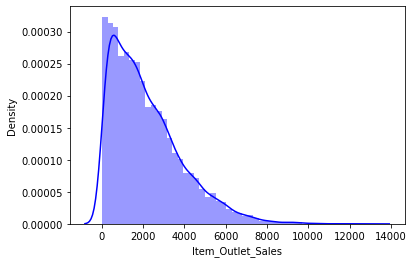

In [40]:
sns.distplot(df_train_set.Item_Outlet_Sales, color='b') # left skewed

In [41]:
df_train_set['Item_Outlet_Sales'] = np.log1p(df_train_set[["Item_Outlet_Sales"]])

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Density'>

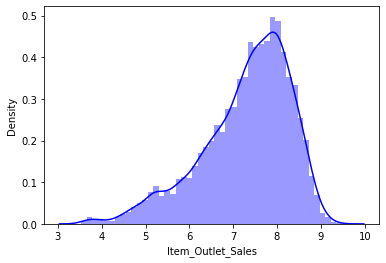

In [42]:
sns.distplot(df_train_set.Item_Outlet_Sales, color='b')

<AxesSubplot:ylabel='Item_Outlet_Sales'>

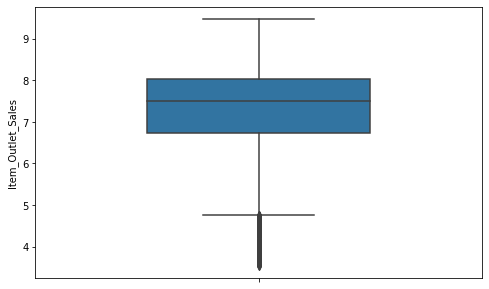

In [43]:
# Outlier Analysis
plt.figure(figsize=(8,5))
sns.boxplot(y=df_train_set['Item_Outlet_Sales'], data=df_train_set, width=0.5)

In [44]:
# identify outliers with interquartile range
from numpy.random import seed
from numpy import percentile
# seed the random number generator
seed(1)
# generate univariate observations
data = df_train_set['Item_Outlet_Sales']
# calculate interquartile range
q25, q75 = percentile(data,25), percentile(data,75)
iqr = q75 - q25
print('Percentiles: 25th = %.3f, 75th = %.3f, IQR = %.3f' % (q25,q75,iqr))
# calculate the outlier cut-off
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in data if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th = 6.728, 75th = 8.040, IQR = 1.312
Identified outliers: 171
Non-outlier observations: 8352


In [45]:
df_train_set_outliers = df_train_set[(df_train_set['Item_Outlet_Sales'] >= lower) & (df_train_set['Item_Outlet_Sales'] <= upper)]

In [46]:
df_train_set_outliers.shape

(8352, 24)

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Density'>

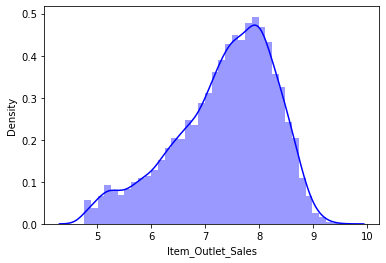

In [47]:
sns.distplot(df_train_set_outliers.Item_Outlet_Sales, color='b')

<AxesSubplot:ylabel='Item_Outlet_Sales'>

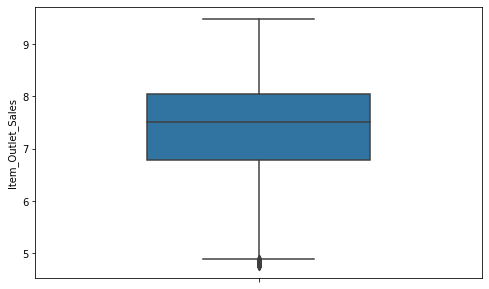

In [48]:
# Outlier Analysis
plt.figure(figsize=(8,5))
sns.boxplot(y=df_train_set_outliers['Item_Outlet_Sales'], data=df_train_set_outliers, width=0.5)

In [49]:
df_train_set_outliers.shape

(8352, 24)

In [50]:
df_train_set_corr = df_train_set_outliers.copy()

In [51]:
df_train_set_corr.dtypes

Item_Weight                        float64
Item_Fat_Content                     int32
Item_Visibility                    float64
Item_MRP                           float64
Outlet_Establishment_Year            int64
Outlet_Size                          int32
Outlet_Location_Type                 int32
Outlet_Type                          int32
Item_Outlet_Sales                  float64
Item_Type_Breads                     uint8
Item_Type_Breakfast                  uint8
Item_Type_Canned                     uint8
Item_Type_Dairy                      uint8
Item_Type_Frozen Foods               uint8
Item_Type_Fruits and Vegetables      uint8
Item_Type_Hard Drinks                uint8
Item_Type_Health and Hygiene         uint8
Item_Type_Household                  uint8
Item_Type_Meat                       uint8
Item_Type_Others                     uint8
Item_Type_Seafood                    uint8
Item_Type_Snack Foods                uint8
Item_Type_Soft Drinks                uint8
Item_Type_S

In [52]:
# Find correlations with the target and sort
correlations = df_train_set_corr.corr()['Item_Outlet_Sales'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 Item_Type_Canned                   0.012025
Item_Type_Household                0.013252
Item_Fat_Content                   0.015402
Item_Type_Fruits and Vegetables    0.018364
Item_Type_Snack Foods              0.027907
Outlet_Establishment_Year          0.042594
Outlet_Location_Type               0.062405
Outlet_Type                        0.442906
Item_MRP                           0.487000
Item_Outlet_Sales                  1.000000
Name: Item_Outlet_Sales, dtype: float64

Most Negative Correlations:
 Outlet_Size                    -0.188003
Item_Visibility                -0.174560
Item_Type_Soft Drinks          -0.022055
Item_Type_Health and Hygiene   -0.020848
Item_Type_Others               -0.016557
Item_Type_Breakfast            -0.014206
Item_Type_Frozen Foods         -0.008753
Item_Type_Seafood              -0.008643
Item_Type_Meat                 -0.004559
Item_Type_Dairy                 0.001665
Name: Item_Outlet_Sales, dtype: float64


Text(0.5, 1.0, 'Correlation between features')

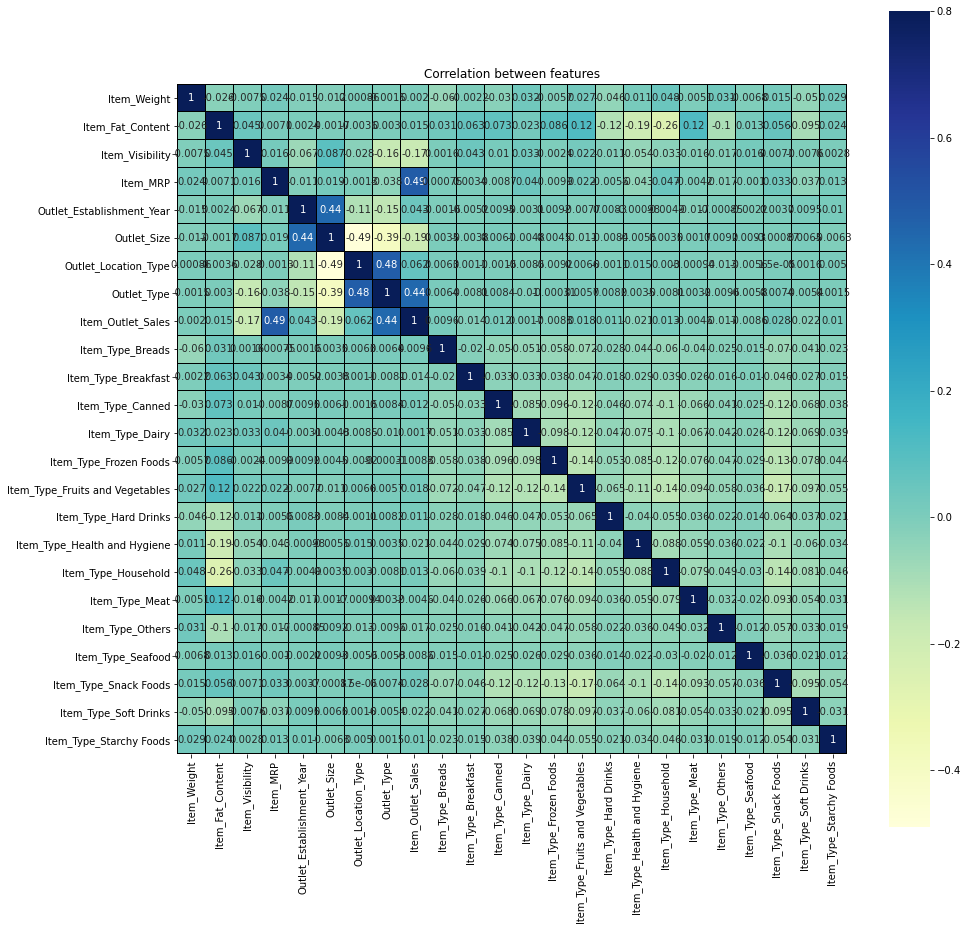

In [53]:
corr = df_train_set_corr.corr() 
plt.figure(figsize=(15,15))
sns.heatmap(corr,vmax=.8,linewidth=.01, square = True, annot = True,cmap='YlGnBu',linecolor ='black')
plt.title('Correlation between features')

In [54]:
X = df_train_set.drop('Item_Outlet_Sales', axis=1)
y = df_train_set['Item_Outlet_Sales']
X_test = df_test_set

In [55]:
X.shape

(8523, 23)

In [56]:
X.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Breads,Item_Type_Breakfast,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,9.30,0,0.016047,249.8092,1999,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.92,1,0.019278,48.2692,2009,1,2,2,0,0,...,0,0,0,0,0,0,0,0,1,0
2,17.50,0,0.016760,141.6180,1999,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [57]:
X.isnull().sum()

Item_Weight                        0
Item_Fat_Content                   0
Item_Visibility                    0
Item_MRP                           0
Outlet_Establishment_Year          0
Outlet_Size                        0
Outlet_Location_Type               0
Outlet_Type                        0
Item_Type_Breads                   0
Item_Type_Breakfast                0
Item_Type_Canned                   0
Item_Type_Dairy                    0
Item_Type_Frozen Foods             0
Item_Type_Fruits and Vegetables    0
Item_Type_Hard Drinks              0
Item_Type_Health and Hygiene       0
Item_Type_Household                0
Item_Type_Meat                     0
Item_Type_Others                   0
Item_Type_Seafood                  0
Item_Type_Snack Foods              0
Item_Type_Soft Drinks              0
Item_Type_Starchy Foods            0
dtype: int64

Feature: 0, Score: 0.0474
Feature: 1, Score: 0.0057
Feature: 2, Score: 0.0648
Feature: 3, Score: 0.3523
Feature: 4, Score: 0.0332
Feature: 5, Score: 0.0056
Feature: 6, Score: 0.0072
Feature: 7, Score: 0.4430
Feature: 8, Score: 0.0017
Feature: 9, Score: 0.0018
Feature: 10, Score: 0.0031
Feature: 11, Score: 0.0033
Feature: 12, Score: 0.0038
Feature: 13, Score: 0.0046
Feature: 14, Score: 0.0014
Feature: 15, Score: 0.0035
Feature: 16, Score: 0.0042
Feature: 17, Score: 0.0025
Feature: 18, Score: 0.0013
Feature: 19, Score: 0.0009
Feature: 20, Score: 0.0046
Feature: 21, Score: 0.0027
Feature: 22, Score: 0.0015


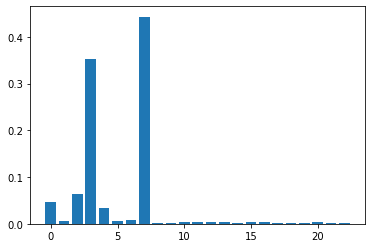

In [58]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

X = df_train_set.drop('Item_Outlet_Sales', axis=1)
y = df_train_set['Item_Outlet_Sales']
# define and fit the model
model = RandomForestRegressor()
model.fit(X,y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.4f' %(i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [60]:
X_train_fs = df_train_set[['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year','Outlet_Type']]
X_test_fs = df_test_set[['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year','Outlet_Type']]

In [63]:
X_train_fs.shape, X_test_fs.shape

((8523, 5), (5681, 5))

In [61]:
# Make a new dataframe for polynomial features
poly_features = X_train_fs
poly_features_test = X_test_fs

In [62]:
poly_target = y

In [64]:
from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [65]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (8523, 56)


In [66]:
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year','Outlet_Type']))


In [67]:
poly_target = pd.DataFrame(poly_target)

In [69]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

# Evaluating Best Model 
X = poly_features
y = poly_target
y = y.values.reshape((len(y),1))

#Scaling 
MN = MinMaxScaler()
X = MN.fit_transform(X)
X_test = MN.transform(poly_features_test)
y = MN.fit_transform(y)

# Model initilization

Lnr = LinearRegression()
SVR_rbf = SVR(kernel = 'linear')
DT = DecisionTreeRegressor()
RDF = RandomForestRegressor()
XR = XGBRegressor()
LGBM = LGBMRegressor()

# Model 

model_list = [Lnr,DT,RDF,XR,SVR_rbf,LGBM]

def best_ml (model,X,y,cv=10): 
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    cross = -cross_val_score(model,X,y,cv=cv,scoring='neg_mean_squared_error').mean()
    final = np.sqrt(cross)
    final_score.append(final)
    
final_score = []

for i in model_list:
    best_ml(i,X,y)

pd.DataFrame(data = final_score,
             columns = ['mean_Squared_error'],
             index = ['LinearRegression','DecisionTree','RandomForest','XGBRegressor','SupVecMach','LGBM'])


,mean_Squared_error
LinearRegression,0.087325
DecisionTree,0.124708
RandomForest,0.093376
XGBRegressor,0.093556
SupVecMach,0.087957
LGBM,0.089199


In [70]:
Lnr.fit(X,y)

LinearRegression()

In [71]:
yhat = Lnr.predict(X_test)
y_re = yhat.reshape((len(yhat),1))
ypred = MN.inverse_transform(y_re)
ypred=np.expm1(ypred)

In [72]:
sub = pd.DataFrame()
sub['Item_Identifier'] = df_test['Item_Identifier']
sub['Outlet_Identifier'] = df_test['Outlet_Identifier']
sub['Item_Outlet_Sales'] = ypred
sub.to_csv('Submission_BMSP_FI.csv',index=False)